Bilayer unit domain. Sigma optimisation

Check installation of FEniCSx and install using Fem on Colab scripts

In [123]:
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-complex.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [124]:
# Importing libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
    dx,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, meshtags
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix, assemble_scalar
import basix
from dolfinx.geometry import bb_tree
from dolfinx import geometry
from petsc4py.PETSc import ScalarType
from slepc4py.SLEPc import EPS  

Domain, PML, refinement and physical configurations

In [125]:
# Define element size for the mesh refinement
h = 0.125/2   # N=1
# h = 0.125/4   # N=2

# h = 0.125/8   # N=3

# Domain configuration
Lx = 1. # fluid domain length (without PML)
l_inner=Lx/2 # position of the interface between both media

# Physical configuration
rho_media_1 = 1. # kg/m^3 
vel_media_1 = 2.   # m/s
rho_media_2 = 1. # kg/m^3 
vel_media_2 = 1.   # m/s


# Define the density and velocity functions  
def rho_function(x):    
    return np.where(x[0] > l_inner, rho_media_2,rho_media_1)

def vel_function(x):    
    return np.where(x[0] > l_inner, vel_media_2,vel_media_1)

# PML configuration
pml_thickness = Lx/4

# Solver configuration
requested_eigenvalues_number = 15 # Number of eigenvalues to compute
target=[-12.56j, 
        -25.13j, 
        -37.69j, 
        -50.26j]  # Target for the shift-and-invert spectral transformation
degree=[3,2]  # Polynomial degree for pressure and velocity


pml_profile= 'singular'

match pml_profile:
    case 'piecewise':
        sigma_sweep=np.linspace(1., 101., 21) #piecewise
    case 'quadratic':
        sigma_sweep=np.linspace(1., 201., 21) #quadratic
    case 'singular':
        sigma_sweep=np.linspace(0.1, 3.1, 21)


Solver configuration and computing

In [126]:
def get_configured_problem(mesh, degrees, sigma_x, target):
    # Initialize dictionaries
    dof = {}
    solver_dict={}
    V_dict={}
    Q_dict={}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Identify the fluid cells
    # fluid_cells = locate_entities(mesh, tdim, lambda x: x[0] <= Lx)

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 
    
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Define the subdomains using a Python function
    def physical_domain(x):
        """Returns True for points in [0, Lx]"""
        return x[0] <= Lx

    def pml_domain(x):
        """Returns True for points in (Lx, Lx + pml_thickness]"""
        return x[0] > Lx

    # Get topology dimension
    tdim = mesh.topology.dim

    # Locate cells in each subdomain
    physical_cells = locate_entities(mesh, tdim, physical_domain)
    pml_cells = locate_entities(mesh, tdim, pml_domain)

    # Create a meshtag to mark the subdomains
    num_cells = mesh.topology.index_map(tdim).size_local
    cell_markers = np.zeros(num_cells, dtype=np.int32)
    cell_markers[physical_cells] = 1  # Physical domain tag
    cell_markers[pml_cells] = 2       # PML domain tag

    cell_tags = meshtags(mesh, tdim, np.arange(num_cells, dtype=np.int32), cell_markers)

    # Now you can use these tags for integration measures
    dx = Measure("dx", domain=mesh, subdomain_data=cell_tags)

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 0))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q) 
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx(2), -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx(2)],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]  
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-16, 100)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert" 
    solver.setTarget(target)  
    solver.solve()
    n_eigs_converged_quadratic = solver.getConverged()

    return solver, mesh, Q, V, dof

In [127]:
def assign_eigenvector_to_functions(vrA, p_h, v_h, dof):
    """
    Reparte o vector eigenvector 'vrA' entre p_h e v_h
    e normaliza no punto 'normalize_at'.
    """

    # --- separar as partes do autovector ---
    p_vals = vrA[:dof["p"]]
    v_vals = vrA[dof["p"]:]

    # asignar
    p_h.x.array[:] = p_vals
    v_h.x.array[:] = v_vals

    return p_h, v_h

In [128]:
def get_exact_eigenpair(selected_index, Q, V, x_hat):
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    w=exact_physical_eigs_function(selected_index)

    # Función de presión en el primer medio
    p_1 = lambda x: np.sin(w * x[0] / vel_media_1)

    # Valor de p_1 en la interfaz
    p_l_inner = p_1([l_inner])

    # Función de presión en el segundo medio, continua
    p_2 = lambda x: p_l_inner * np.exp(1j * w / vel_media_2 * (x_hat(x, w) - l_inner))

    # Función de presión completa
    p = lambda x: np.where(x[0] >= l_inner, p_2(x), p_1(x))

    # Velocidad en el primer medio
    def v_1(x):
        return ((-1j/(rho_media_1*vel_media_1)) * np.cos(w * x[0] / vel_media_1))

    # Velocidad en el segundo medio, continua con la interfaz
    def v_2(x):
        return p_1([l_inner])/(rho_media_2*vel_media_2) * np.exp(1j * w / vel_media_2 * (x_hat(x, w) - l_inner))

    # Función de velocidad completa
    v = lambda x: np.where(x[0] >= l_inner, v_2(x), v_1(x))

    p_ex = Function(Q, name="p_ex")
    p_ex.interpolate(p)

    v_ex = Function(V, name="v_ex")
    v_ex.interpolate(v)

    return [w, p_ex, v_ex]

In [129]:
def project_exact_to_mesh(u_exact, Vh):
    """
    Proxecta/interpola unha expresión exacta (UFL) ou un Function
    doutra malla ao espazo funcional Vh (malla actual).

    Funciona en dolfinx 0.9 e evita todos os problemas de dimensión
    e de Expression nos MixedElements.
    """

    # Se u_exact xa é un Function no mesmo espazo, devolver directamente
    if isinstance(u_exact, Function) and u_exact.function_space == Vh:
        return u_exact

    # Crear Function sobre Vh
    u_proj = Function(Vh)

    # Caso 1: exacta é Function doutra malla -> interpolar
    if isinstance(u_exact, Function):
        u_proj.interpolate(u_exact)
        return u_proj

    # Caso 2: exacta é UFL Expression -> interpolar mediante Expression
    # Obter puntos de interpolación (DOF coordinates)
    X = Vh.tabulate_dof_coordinates()

    # Se é 1D pero X ven con máis dimensións, quedar coa primeira columna
    if X.ndim == 2 and X.shape[1] > 1:
        X = X[:, :1]

    expr = Expression(u_exact, X, dtype=u_proj.x.array.dtype)
    u_proj.interpolate(expr)

    return u_proj


In [130]:
def eigenvector_L2_error_physical(u_num, u_exact, Lx, mesh):
    """
    Erro relativo L2 só no dominio físico [0, Lx] en DOLFINx 0.9.
    Alinea fase/signo antes de medir o erro.
    """

    import numpy as np
    import ufl
    from ufl import inner
    from dolfinx.mesh import locate_entities, meshtags
    from dolfinx.fem import form, assemble_scalar

    
    tdim = mesh.topology.dim

    # --- 1) Localizar celas físicas ---
    cells_phys = locate_entities(
        mesh, tdim,
        lambda x: np.logical_and(x[0] >= 0, x[0] < Lx)
    )

    if len(cells_phys) == 0:
        raise RuntimeError("Non se detectaron celas na rexión física [0, Lx].")

    # Asignar etiqueta 1
    values = np.full(len(cells_phys), 1, dtype=np.int32)
    mt = meshtags(mesh, tdim, cells_phys, values)

    # Medida restrinxida
    dx_phys = ufl.Measure("dx", domain=mesh, subdomain_data=mt)
    
    # --- 3) Norma L2 do erro no dominio físico ---
    diff = u_num - u_exact

    num = np.sqrt(assemble_scalar(form(inner(diff, diff) * dx_phys(1))))
    den = np.sqrt(assemble_scalar(form(inner(u_exact, u_exact) * dx_phys(1))))

    return num / den


In [131]:
def eval_point_fast(u, bb, x, mesh):
    pt = np.array([x, 0.0, 0.0], dtype=np.float64)

    # 1) Buscamos celas candidatas no árbol
    candidates = geometry.compute_collisions_points(bb, pt)

    # 2) Filtramos celas que realmente conteñen o punto
    cell = geometry.compute_colliding_cells(mesh, candidates, pt)

    if len(cell) == 0:
        return np.nan

    # 3) Avaliar a función FEM
    P = np.array([pt])
    C = np.array([cell.array[0]], dtype=np.int32)

    val = u.eval(P, C)
    return val[0]

In [132]:
def normalize_at_Lx(u, bb, Lx, mesh):
    val_Lx = eval_point_fast(u, bb, Lx, mesh)
    u.x.array[:] /= val_Lx   # normalizando respecto do valor en [Lx, 0, 0]
    return u

In [133]:
def get_closest_approx_eigenpair(exact_eigenvalue_idx, solver, Q, V, dof, sigma_i, mesh, verbose=False, plot=False):
    """
    Devuelve el autovalor y autovector más cercano a omega_target
    usando distancia compleja |λ - λ_target|, sin usar get_approx_eigenpair.

    Returns
    -------
    lambda_best : complex
    x_best : PETSc.Vec (copia del autovector)
    idx_best : int (índice raw en solver)
    p_h:    Function
    v_h: Function
    """
    p_exact = [None] * 5  # Almacena los autovectores exactos de presión
    v_exact = [None] * 5  # Almacena los autovectores exactos de velocidad
    p_approx = [None] * 5  # Almacena los autovectores exactos de presión
    v_approx = [None] * 5  # Almacena los autovectores exactos de velocidad
    best = None
    best_3 = None

    # Vector temporal para extraer Eigenpairs
    p_h = Function(Q, name="p_h")
    v_h = Function(V, name="v_h")

    # Número de modos convergidos
    nconv = solver.getConverged()
    if nconv == 0:
        raise RuntimeError("No hay autovalores convergidos")

    # Vector temporal para extraer Eigenpairs
    vrA, vi = solver.getOperators()[0].getVecs()

    match pml_profile:
        case 'piecewise':
            x_hat = lambda x, w: np.where(x[0] >= Lx, x[0] + (1j / w) * sigma_i * (x[0] - Lx), x[0])
            # sigma_py=lambda x: (np.abs(x[0]) > Lx) * sigma_i 

        case 'quadratic':
            x_hat=lambda x, w: np.where(x[0] >= Lx, x[0]+1j/ w* sigma_i* (np.abs(x[0]) - Lx) ** 3/ (3 * pml_thickness**2), x[0])
            # sigma_py=lambda x: (np.abs(x[0]) > Lx) * sigma_i * (np.abs(x[0]) - Lx) ** 2 / (pml_thickness ** 2)

        case 'singular':
            x_hat=lambda x, w: np.where(x[0] >= Lx, x[0]+ (1j / w)*sigma_i* (-np.log(Lx + pml_thickness- np.abs(x[0]))), x[0])
            # sigma_py=lambda x: (np.abs(x[0]) > Lx) * sigma_i / (Lx + pml_thickness - np.abs(x[0]))
    
    [exact_eigenvalue, p_exact, v_exact] =   get_exact_eigenpair(exact_eigenvalue_idx, Q, V, x_hat)

    bb = bb_tree(mesh, mesh.topology.dim)
    for k in range(nconv):
        approx_eigenvalue = solver.getEigenvalue(k) * 1j 
        solver.getEigenpair(k, vrA)  
        # Vector temporal para extraer Eigenpairs
        p_h = Function(Q, name="p_h")
        v_h = Function(V, name="v_h")
        [p_h, v_h]=assign_eigenvector_to_functions(vrA = vrA, p_h = p_h, v_h = v_h, dof = dof)

        # --- autovalores ---
        err_eig = abs(approx_eigenvalue - exact_eigenvalue) / abs(exact_eigenvalue)

        # --- autovectores ---

        p_h=normalize_at_Lx(p_h, bb, Lx, mesh)
        v_h=normalize_at_Lx(v_h, bb, Lx, mesh)
        p_exact=normalize_at_Lx(p_exact, bb, Lx, mesh)
        v_exact=normalize_at_Lx(v_exact, bb, Lx, mesh)


        # Errores L2 en dominio físico
        err_p = eigenvector_L2_error_physical(p_h, p_exact, Lx, mesh)
        err_v = eigenvector_L2_error_physical(v_h, v_exact, Lx, mesh)

        # Total
        err = (err_eig + err_p + err_v) / 3
        

        if best is None or err < best[2]:
            best = (approx_eigenvalue, k, err,err_eig, err_p, err_v)

    closest_eig, idx_best, rel_err_total, rel_err_eig_best, rel_err_p_best, rel_err_v_best = best

    # Vector temporal para extraer Eigenpairs
    p_h = Function(Q, name="p_h")
    v_h = Function(V, name="v_h")
    vrA, vi = solver.getOperators()[0].getVecs()
    solver.getEigenpair(idx_best, vrA)
    [p_approx, v_approx]=assign_eigenvector_to_functions(vrA = vrA, p_h = p_h, v_h = v_h, dof = dof)

    if verbose:
        print(f"$\sigma_i={sigma_i}$")
        print(f"$[Closest to \omega={exact_eigenvalue}] idx={idx_best}  \omega={closest_eig}  \epsilon_r={(rel_err_eig_best+rel_err_p_best+rel_err_v_best)/3} \epsilon_r(\omega)={rel_err_eig_best}  \epsilon_r(p)={rel_err_p_best} \epsilon_r(v)={rel_err_v_best}$")


    if plot:
        from dolfinx import geometry

        fig, axes = plt.subplots(1, 2, figsize=(12,8))

        # ============================================================
        #  FILA 1 — AUTOVECTORES p
        # ============================================================

        # --- p, modo 0 ---
        ax = axes[0]
        

        val_Lx = eval_point_fast(p_approx, bb, Lx, mesh)
        p_approx.x.array[:] /= val_Lx   # normalizando respecto do valor en [Lx, 0, 0]
        val_Lx = eval_point_fast(p_exact, bb, Lx, mesh)
        p_exact.x.array[:] /= val_Lx
        xx = np.linspace(0, Lx+pml_thickness, 2000)
        yy = [eval_point_fast(p_approx, bb, x, mesh) for x in xx]
        ax.plot(xx, np.real(yy), label="Re(p)", linestyle="-.")
        yy = [eval_point_fast(p_exact, bb, x, mesh) for x in xx]
        ax.plot(xx, np.real(yy), label="Re(p)", linestyle="-")
        ax.set_xlabel("x [m]")
        ax.set_ylabel("p(x) [Pa]")
        ax.set_title("Modo {} con sigma singular".format(0))
        ax.grid(True)


        ax = axes[1]
        val_Lx = eval_point_fast(v_approx, bb, Lx, mesh)
        v_approx.x.array[:] /= val_Lx   # normalizando respecto do valor en [Lx, 0, 0]
        val_Lx = eval_point_fast(v_exact, bb, Lx, mesh)
        v_exact.x.array[:] /= val_Lx
        xx = np.linspace(0, Lx+pml_thickness, 2000)
        yy = [eval_point_fast(v_approx, bb, x, mesh) for x in xx]
        ax.plot(xx, np.real(yy), label="Re(v)", linestyle="-.")
        yy = [eval_point_fast(v_exact, bb, x, mesh) for x in xx]
        ax.plot(xx, np.real(yy), label="Re(v)", linestyle="-")        
        ax.set_xlabel("x [m]")
        ax.set_ylabel("v(x) ")
        ax.grid(True)

        plt.show()

    return exact_eigenvalue, p_exact, v_exact, closest_eig, p_approx, v_approx, rel_err_eig_best, rel_err_p_best, rel_err_v_best, (rel_err_eig_best + rel_err_p_best + rel_err_v_best) / 3


In [134]:
results_sigma = {}

# Crear nova malla para este refinamento
mesh = create_interval(
    MPI.COMM_WORLD,
    int((Lx + pml_thickness) / h),
    [0, Lx + pml_thickness]
)
bb = bb_tree(mesh, mesh.topology.dim)
for i, sigma_i in enumerate(sigma_sweep):
    match pml_profile:
        case 'piecewise':
            print(f"Computing for sigma_i = {sigma_i:.2f} (piecewise)")
            sigma_function = lambda x: sigma_i
        case 'quadratic':
            print(f"Computing for sigma_i = {sigma_i:.2f} (quadratic)")
            sigma_function = lambda x: sigma_i * (x[0] - Lx)**2 / (pml_thickness**2)
        case 'singular':
            print(f"Computing for sigma_i = {sigma_i:.2f} (singular)")
            sigma_function = lambda x: sigma_i/(Lx+pml_thickness-x[0])

    # configurar problemas
    solver_target_0, mesh, Q_, V_, dof_ = get_configured_problem(mesh, degree, sigma_function, target[0])
    solver_target_1, mesh, Q_, V_, dof_ = get_configured_problem(mesh, degree, sigma_function, target[1])
    solver_target_2, mesh, Q_, V_, dof_ = get_configured_problem(mesh, degree, sigma_function, target[2])
    solver_target_3, mesh, Q_, V_, dof_ = get_configured_problem(mesh, degree, sigma_function, target[3])



# get_closest_approx_eigenpair(exact_eigenvalue_idx, solver, Q, V, dof, sigma_i, mesh, verbose=False, plot=False)
    out_0 = get_closest_approx_eigenpair(1, solver_target_0, Q_, V_, dof_, sigma_i, mesh)
    # modo 1
    out_1 = get_closest_approx_eigenpair(2, solver_target_1, Q_, V_, dof_, sigma_i, mesh)
    # modo 2
    out_2 = get_closest_approx_eigenpair(3, solver_target_2, Q_, V_, dof_, sigma_i, mesh)
    # modo 3
    out_3 = get_closest_approx_eigenpair(4, solver_target_3, Q_, V_, dof_, sigma_i, mesh)
    # guardar resultados
    results_sigma[sigma_i] = {
        0: {
            'eig_exact':   out_0[0],
            'p_exact':     out_0[1],
            'v_exact':     out_0[2],
            'eig_approx':  out_0[3],
            'p_approx':    out_0[4],
            'v_approx':    out_0[5],
            'err_eig':     out_0[6],
            'err_p':       out_0[7],
            'err_v':       out_0[8],
            'err_total':   out_0[9],
        },
        1: {
            'eig_exact':   out_1[0],
            'p_exact':     out_1[1],    
            'v_exact':     out_1[2],
            'eig_approx':  out_1[3],
            'p_approx':    out_1[4],
            'v_approx':    out_1[5],
            'err_eig':     out_1[6],
            'err_p':       out_1[7],
            'err_v':       out_1[8],
            'err_total':   out_1[9],
        },
        2: {
            'eig_exact':   out_2[0],
            'p_exact':     out_2[1],
            'v_exact':     out_2[2],
            'eig_approx':  out_2[3],                
            'p_approx':    out_2[4],
            'v_approx':    out_2[5],
            'err_eig':     out_2[6],
            'err_p':       out_2[7],
            'err_v':       out_2[8],
            'err_total':   out_2[9],
        },
        3: {
            'eig_exact':   out_3[0],
            'p_exact':     out_3[1],
            'v_exact':     out_3[2],
            'eig_approx':  out_3[3],
            'p_approx':    out_3[4],
            'v_approx':    out_3[5],
            'err_eig':     out_3[6],
            'err_p':       out_3[7],
            'err_v':       out_3[8],
            'err_total':   out_3[9],
        }
    }



Computing for sigma_i = 0.10 (singular)
Computing for sigma_i = 0.25 (singular)
Computing for sigma_i = 0.40 (singular)
Computing for sigma_i = 0.55 (singular)
Computing for sigma_i = 0.70 (singular)
Computing for sigma_i = 0.85 (singular)
Computing for sigma_i = 1.00 (singular)
Computing for sigma_i = 1.15 (singular)
Computing for sigma_i = 1.30 (singular)
Computing for sigma_i = 1.45 (singular)
Computing for sigma_i = 1.60 (singular)
Computing for sigma_i = 1.75 (singular)
Computing for sigma_i = 1.90 (singular)
Computing for sigma_i = 2.05 (singular)
Computing for sigma_i = 2.20 (singular)
Computing for sigma_i = 2.35 (singular)
Computing for sigma_i = 2.50 (singular)
Computing for sigma_i = 2.65 (singular)
Computing for sigma_i = 2.80 (singular)
Computing for sigma_i = 2.95 (singular)
Computing for sigma_i = 3.10 (singular)


In [135]:
def plot_mode_sigma(eig, sigma_i, bb):

    data = results_sigma[sigma_i][eig]

    # --- COPIAS (clave para sliders) ---
    p_exact  = data['p_exact'].copy()
    p_approx = data['p_approx'].copy()
    v_exact  = data['v_exact'].copy()
    v_approx = data['v_approx'].copy()
    eig_approx = data['eig_approx']
    eig_exact = data['eig_exact']

    fig, axes = plt.subplots(1, 2, figsize=(12, 8))

    xx = np.linspace(0, Lx + pml_thickness, 500)

    # ---------------- p ----------------
    ax = axes[0]
    val_Lx = eval_point_fast(p_exact, bb, Lx, mesh)
    p_exact.x.array[:] /= val_Lx
    yy = [eval_point_fast(p_exact, bb, x, mesh) for x in xx]
    ax.plot(xx, np.real(yy), label="Re(p) exact", linestyle="-")


    val_Lx = eval_point_fast(p_approx, bb, Lx, mesh)
    p_approx.x.array[:] /= val_Lx
    yy = [eval_point_fast(p_approx, bb, x, mesh) for x in xx]
    ax.plot(xx, np.real(yy), label="Re(p) approx", linestyle="-.")

    ax.set_xlabel("x [m]")
    ax.set_ylabel("p(x) [Pa]")
    ax.grid(True)
    ax.set_ylim([-1.1,1.1])
    # ax.set_xlim([1,Lx+pml_thickness])
    ax.legend()

    # ---------------- v ----------------
    ax = axes[1]

    val_Lx = eval_point_fast(v_exact, bb, Lx, mesh)
    v_exact.x.array[:] /= val_Lx
    yy = [eval_point_fast(v_exact, bb, x, mesh) for x in xx]
    ax.plot(xx, np.real(yy), label="Re(v) exact", linestyle="-")

    val_Lx = eval_point_fast(v_approx, bb, Lx, mesh)
    v_approx.x.array[:] /= val_Lx
    yy = [eval_point_fast(v_approx, bb, x, mesh) for x in xx]
    ax.plot(xx, np.real(yy), label="Re(v) approx", linestyle="-.")



    ax.set_xlabel("x [m]")
    ax.set_ylabel("v(x)")
    ax.grid(True)
    ax.set_ylim([-1.1, 1.1])
    # ax.set_xlim([1,Lx+pml_thickness])
    ax.legend()


    fig.suptitle(f"Sigma {pml_profile} | Modo {eig} | $\omega_{{ex}}$= {eig_exact} |$\omega_h$= {eig_approx} | sigma = {sigma_i}")
    plt.tight_layout()
    plt.show()


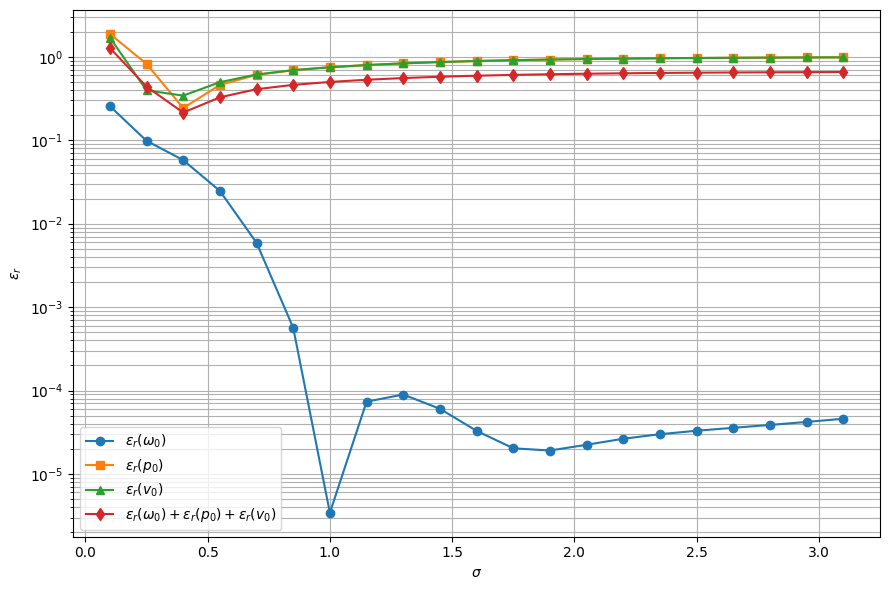

In [136]:
eigenvalue=0
import numpy as np
import matplotlib.pyplot as plt

sigmas = []
err_eig = []
err_p = []
err_v = []
err_total = []

for sigma_i in sigma_sweep:
    data = results_sigma[sigma_i][eigenvalue]

    # índice do modo con menor erro total
    j_min = np.argmin(data['err_total'])

    sigmas.append(sigma_i)
    err_eig.append(data['err_eig'])
    err_p.append(data['err_p'])
    err_v.append(data['err_v'])
    err_total.append(data['err_total'])

sigmas = np.array(sigmas)

# Plot
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(sigmas, err_eig, marker='o', label=rf'$\epsilon_r(\omega_{eigenvalue})$')
ax.plot(sigmas, err_p, marker='s', label=rf'$\epsilon_r(p_{eigenvalue})$')
ax.plot(sigmas, err_v, marker='^', label=rf'$\epsilon_r(v_{eigenvalue})$')
ax.plot(sigmas, err_total, marker='d', label=rf'$\epsilon_r(\omega_{eigenvalue})+\epsilon_r(p_{eigenvalue})+\epsilon_r(v_{eigenvalue})$')

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('$\epsilon_r$')
ax.set_yscale('log')
ax.grid(True, which='both')
ax.legend()

plt.tight_layout()
plt.show()


sigma=0.1, mode=0, err_total=(1.2807760116862517+0j)
sigma=0.25, mode=0, err_total=(0.43938346175558635+0j)
sigma=0.4, mode=0, err_total=(0.21472584906842118+0j)
sigma=0.5499999999999999, mode=0, err_total=(0.3273002302918694+0j)
sigma=0.7, mode=0, err_total=(0.4094595204084809+0j)
sigma=0.85, mode=0, err_total=(0.4614063547362542+0j)
sigma=0.9999999999999999, mode=0, err_total=(0.5002165047794316+0j)
sigma=1.1500000000000001, mode=0, err_total=(0.5314479587435376+0j)
sigma=1.3, mode=0, err_total=(0.5568378725334414+0j)
sigma=1.45, mode=0, err_total=(0.5774656747484902+0j)
sigma=1.6, mode=0, err_total=(0.5942160650221688+0j)
sigma=1.75, mode=0, err_total=(0.6078192976038903+0j)
sigma=1.9, mode=0, err_total=(0.6188688250693661+0j)
sigma=2.05, mode=0, err_total=(0.6278446657540451+0j)
sigma=2.2, mode=0, err_total=(0.6351359950288862+0j)
sigma=2.35, mode=0, err_total=(0.6410588138526837+0j)
sigma=2.5, mode=0, err_total=(0.6458698872440225+0j)
sigma=2.65, mode=0, err_total=(0.6497778948984

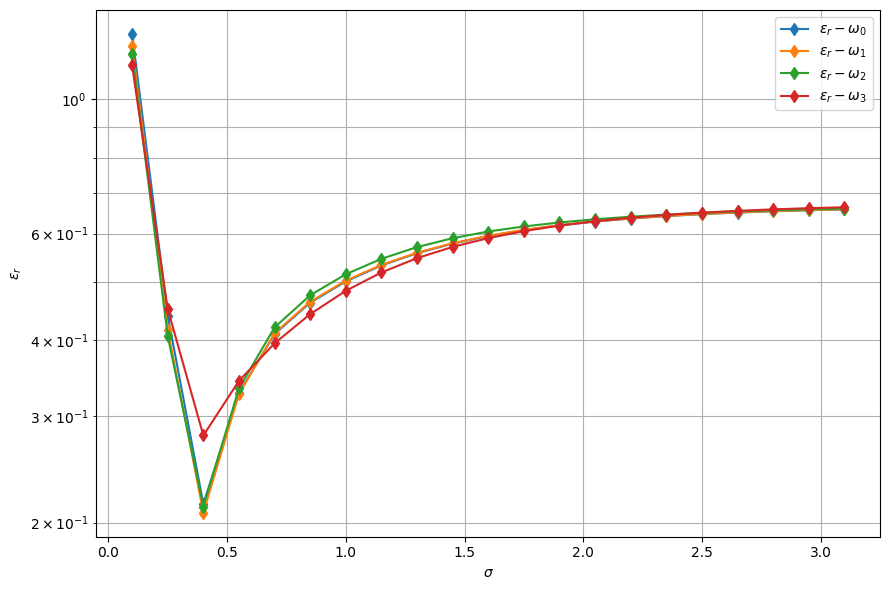

In [137]:
import numpy as np
import matplotlib.pyplot as plt

sigmas = []
err_total = []
# Plot
fig, ax = plt.subplots(figsize=(9, 6))

for i in [0,1,2,3]:
    err_total = []

    for sigma_i in sigma_sweep:
        data = results_sigma[sigma_i][i]

        # índice do modo con menor erro total
        j_min = np.argmin(data['err_total'])

        err_eig.append(data['err_eig'])
        err_p.append(data['err_p'])
        err_v.append(data['err_v'])
        err_total.append(data['err_total'])
        print(f"sigma={sigma_i}, mode={i}, err_total={data['err_total']}")
        if i==0: 
            sigmas.append(sigma_i)
    if i==0:
        sigmas = np.array(sigmas)
    ax.plot(sigmas, err_total, marker='d', label=rf'$\epsilon_r - \omega_{i}$')

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('$\epsilon_r$')
ax.set_yscale('log')
ax.grid(True, which='both')
ax.legend()

plt.tight_layout()
plt.show()


In [138]:
sigma = sigma_sweep[7]

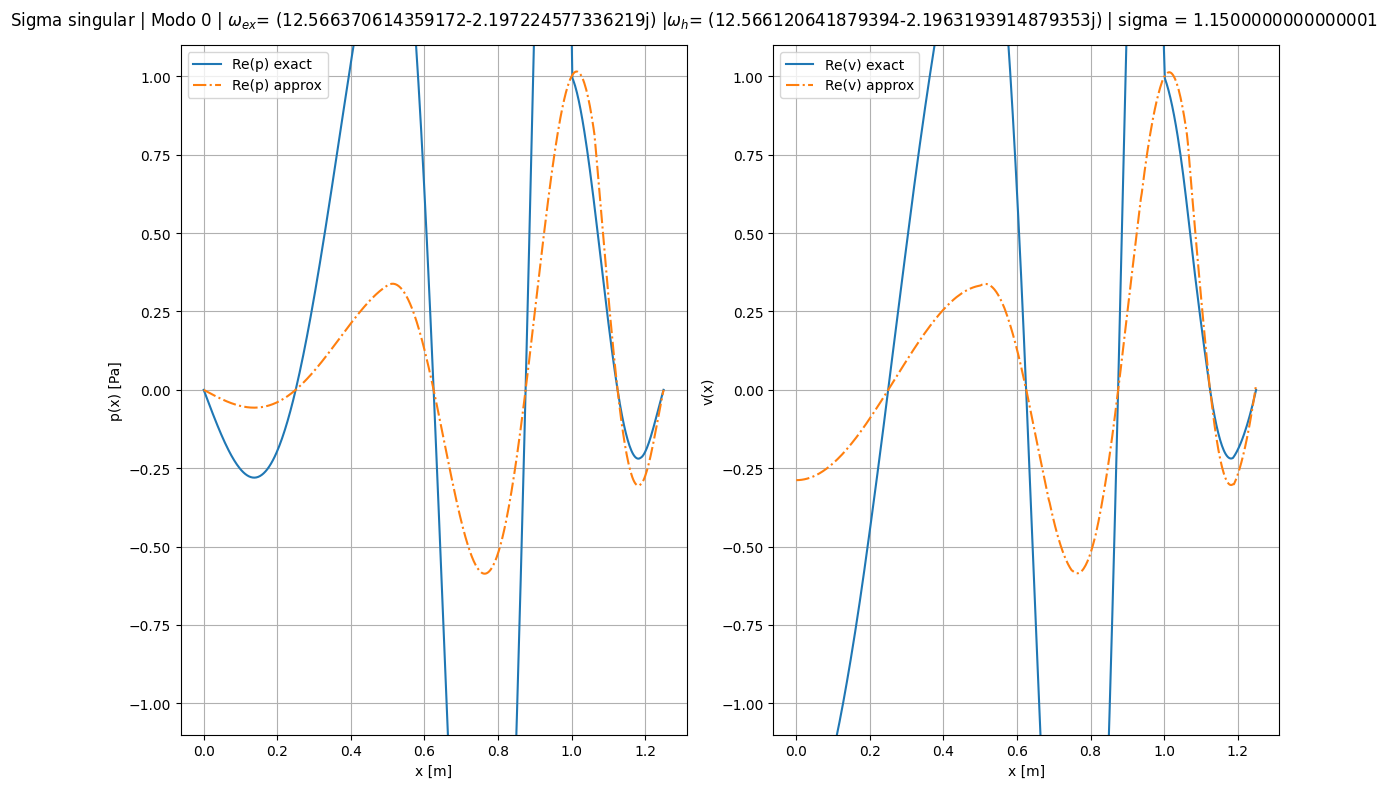

In [139]:
plot_mode_sigma(eig=0, sigma_i=sigma, bb=bb)

In [140]:
# data = results_sigma[sigma][eigenvalue]

# err_total = data['err_total']
# err_eig = data['err_eig']
# err_p = data['err_p']
# err_v = data['err_v']
# print(f"Errors for sigma = {sigma}, mode {eigenvalue}:")
# for i, err in enumerate(err_total):
#     print(f"Mode {i}:")
#     print(f"ε(ω)= {err_eig[i]:.3e}, ε(p)= {err_p[i]:.3e}, ε(v)= {err_v[i]:.3e}, ε(ω)+ε(p)+ε(v) = {err:.3e}$")
